<a href="https://colab.research.google.com/github/juno2856/deeplearning/blob/master/NLP/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_20220525.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://seong6496.tistory.com/110
https://wikidocs.net/22886
https://childult-programmer.tistory.com/54
https://www.sallys.space/blog/2018/02/28/rnn-lstm/

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Tanh를 구현해봅시다

In [ ]:
class Tanh(Model):
    def call(self, x):
        return 2 / (1 + tf.exp(-2*x)) - 1

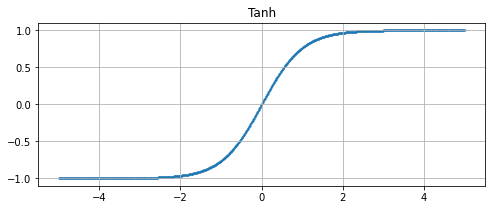

In [ ]:
x = tf.linspace(-5, 5, 1000)
y = Tanh()(x)

plt.figure(figsize=[8, 3])
plt.title('Tanh')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

# Dense층을 구현하세요

In [ ]:
class Dense(Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.w = tf.random.normal(shape=(input_dim, output_dim))
        self.b = tf.zeros(shape=(output_dim))
        
    def call(self, x):
        # (batch, input_dim)
        y = x @ self.w + self.b
        # y = W * x + b
        # print(self.w)
        # @ --> tf.matmul ---> np.dot
        pass
        
        return y

In [ ]:
t = tf.random.normal((2, 256))
t = Dense(256, 512)(t)
print(t.shape)

(2, 512)


# RNN셀을 구현하세요

$$h^{\prime}=\tanh \left(W_{x h} x+b_{x h}+W_{h h} h+b_{h h}\right)$$

In [ ]:
class RNNCell(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.dense1 = Dense(input_dim, hidden_dim)
        self.dense2 = Dense(hidden_dim, hidden_dim)
        self.activation = activation()

        pass        
    
    def call(self, x, h):
        # x : (batch, input_dim)
        h = self.activation(self.dense1(x) + self.dense2(h))
        
        pass

        return h

In [ ]:
x = tf.random.normal((2, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = RNNCell(16, 32)(x,h)
print(y.shape)

(2, 32)


RNN는 RNNCell을 sub-layer로 갖고 있습니다.

forward pass를 구현하는 call에서 for loop 통해 매 time step의 vector를 RNNCell에 넣고 hidden state를 출력합니다.

출력된 hidden state는 다음 time step의 hidden state 입력으로 들어갑니다.

첫번째 time step에서는 주어진 hidden state가 없으므로 tf.zeros를 이용하여 0으로 채운 벡터를 사용합니다.

모든 time step의 출력은 for loop이 끝난 뒤, tf.stack 명령을 통해 쌓아서 최종 출력으로 만듭니다.

In [ ]:
class RNN(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn_cell = RNNCell(input_dim, hidden_dim, activation)
        pass 
    
    def call(self, x):
        # x : (batch, length(timestep), input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 설정
        y = []
        for l in range(length):
            x_ = x[:, l, :]
            h = self.rnn_cell(x_, h)
            y.append(h)
        y = tf.stack(y, axis = 1)

        return y 

In [ ]:
x = tf.random.normal((2, 100, 16)) # input dim

y = RNN(16, 32)(x)
print(y.shape)

(2, 100, 32)


# GRUCell을 구현해봅시다.

\begin{aligned}
&r=\sigma\left(W_{i r} x+b_{i r}+W_{h r} h+b_{h r}\right) \\
&z=\sigma\left(W_{i z} x+b_{i z}+W_{h z} h+b_{h z}\right) \\
&n=\tanh \left(W_{i n} x+b_{i n}+r *\left(W_{h n} h+b_{h n}\right)\right) \\
&h^{\prime}=(1-z) * n+z * h
\end{aligned}

In [ ]:
class Sigmoid(Model):
    def call(self, x):
        return 1 / (1 + np.exp(-x))

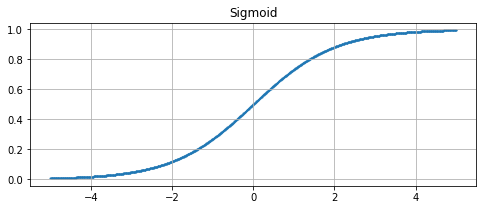

In [ ]:
x = tf.linspace(-5, 5, 1000)
y = Sigmoid()(x)

plt.figure(figsize=[8, 3])
plt.title('Sigmoid')
plt.scatter(x, y, s=1)
plt.grid()
plt.show()

In [ ]:
class GRUCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense_ir = Dense(input_dim, hidden_dim)
        self.dense_hr = Dense(hidden_dim, hidden_dim)
        self.dense_iz = Dense(input_dim, hidden_dim)
        self.dense_hz = Dense(hidden_dim, hidden_dim)
        self.dense_in = Dense(input_dim, hidden_dim)
        self.dense_hn = Dense(hidden_dim, hidden_dim)

        pass

    def call(self, x, h):
        # x : (batch, input_dim)
        # h : (batch, hidden_dim)
        r = self.sigmoid(self.dense_ir(x)+self.dense_hr(h))
        z = self.sigmoid(self.dense_iz(x)+self.dense_hz(h))
        n = self.tanh(self.dense_in(x)+ r*self.dense_hn(h))
        h = (1-z)*n + z*h
        pass

        return h

In [ ]:
x = tf.random.normal((2, 16)) # input dim
h = tf.random.normal((2, 32)) # hidden dim

y = GRUCell(16, 32)(x,h)
print(y.shape)

(2, 32)


In [ ]:
class GRU(Model):
    def __init__(self, input_dim, hidden_dim, activation=Tanh):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gru_cell = GRUCell(input_dim, hidden_dim)
    
    def call(self, x):
        # x : (batch, length(timestep), input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 설정
        y = []
        for l in range(length):
            x_ = x[:, l, :]
            h = self.gru_cell(x_, h)
            y.append(h)     
        y = tf.stack(y, axis=1)
        return y

In [ ]:
x = tf.random.normal((2, 100, 16))
y = GRU(16, 32)(x)
print(y.shape)

(2, 100, 32)


### LSTM을 구현해봅시다.

\begin{aligned}
&i=\sigma\left(W_{i i} x+b_{i i}+W_{h i} h+b_{h i}\right) \\
&f=\sigma\left(W_{i f} x+b_{i f}+W_{h f} h+b_{h f}\right) \\
&g=\tanh \left(W_{i g} x+b_{i g}+W_{h g} h+b_{h g}\right) \\
&o=\sigma\left(W_{i o} x+b_{i o}+W_{h o} h+b_{h o}\right) \\
&c^{\prime}=f * c+i * g \\
&h^{\prime}=o * \tanh \left(c^{\prime}\right)
\end{aligned}

In [ ]:
class LSTMCell(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.sigmoid = Sigmoid()
        self.tanh = Tanh()
        self.dense = Dense(input_dim + hidden_dim, hidden_dim*4)

    
    def call(self, x, state):
        # x : (batch, input_dim)
        # state : (batch, hidden_dim), (batch, hidden_dim)
        h,c = state
        
        # (batch, input_dim + hidden_dim)
        xh = np.concatenate([x,h], axis = 1)
        
        # (batch, hidden_dim*4)
        d = self.dense(xh)

        i,f,g,o = tf.split(d, 4, axis =1)

        i = self.sigmoid(i)
        f = self.sigmoid(f)
        g = self.tanh(g)
        o = self.sigmoid(o)
        c_= f*c + i*g
        h_ = o* self.tanh(c_)

        return h_, c_

In [ ]:
class LSTM:
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm_cell = LSTMCell(input_dim, hidden_dim)
    
    def __call__(self, x):
        # x : (batch, length, input_dim)
        batch, length, input_dim = x.shape

        h = tf.zeros((batch, self.hidden_dim)) # 초기 벡터를 0으로 초기화
        c = tf.zeros((batch, self.hidden_dim))

        y = [] #결과를 저장할 곳의 초기화 (빈 리스트)
        for l in range(length):
            # batch, length, input_dim
            x_ = x[:, l, :]        
            h, c = self.lstm_cell(x_, (h,c))
            y.append(h)
        y = tf.stack(y, axis=1)
        return y

In [ ]:
x = tf.random.normal((2, 100, 16))
y = LSTM(16, 32)(x)
print(y.shape)

(2, 100, 32)
